# Week 8 - K Nearest Neighbors

#### <font color='plum'> RESPONSES IN THIS COLOR

For Week 8,  include ideas such as K-Nearest Neighbors and distance metrics.

# Imports

In [92]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import kagglehub 
import time

from sklearn.impute         import SimpleImputer
from sklearn.compose        import ColumnTransformer
from sklearn.pipeline       import Pipeline
from sklearn.svm            import SVC
from sklearn.base           import BaseEstimator
from sklearn.decomposition  import PCA
from sklearn.preprocessing  import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble       import RandomForestClassifier
from sklearn.datasets       import make_regression
from sklearn.tree           import DecisionTreeClassifier, plot_tree

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from scipy.stats import randint as sp_randint

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    RepeatedStratifiedKFold, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold, 
    cross_val_predict, 
    cross_validate, 
    StratifiedKFold, 
    KFold
)

from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    root_mean_squared_error,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score, 
    make_scorer, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

# from imblearn.ensemble  import BalancedRandomForestClassifier

from datetime           import datetime, timedelta
from tqdm               import tqdm
from typing             import Any, Dict, List, Union, Tuple
from collections        import Counter
from scipy.stats        import randint
# from imblearn.over_sampling import SMOTE


%matplotlib inline

from kagglehub              import KaggleDatasetAdapter


In [110]:
sns.set_theme(font_scale=0.8) 
# plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

# Utility Functions

In [94]:
# globals
random_state    = 42
test_size       = 0.2
n_jobs          = -1
font_size       = 8

In [95]:
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [109]:
def format_time(seconds):
    ''' Convert seconds to hours, minutes, and remaining seconds then Return a formatted string '''
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours               = int(seconds // 3600)
    minutes             = int((seconds % 3600) // 60)
    remaining_seconds   = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

#### reorder_columns

In [97]:
def reorder_columns(df: pd.DataFrame, col_names: list) -> pd.DataFrame:
    missing_columns = set(col_names) - set(df.columns)
    # if missing_columns:
    #     raise ValueError(f"Missing columns: {missing_columns}")
    
    for col in missing_columns:
        df[col] = np.nan

    df = df[col_names]
    return df

#### null counts

In [ ]:
def show_null_counts_features(df: pd.DataFrame) -> pd.DataFrame:
    """
        Identifies and summarizes columns with missing values in given dataframe .

        Steps performed:
            1. Count Null Values: Calculates the total number of null values in each column.
            2. Calculate Null Percentage: Computes the percentage of null values for each column, rounded to two decimal places.
            3. Determine Feature Types: Identifies whether each column is numeric or categorical based on its data type.
            4. Filter and Sort Columns: Filters out columns without missing values and sorts the remaining columns in descending order of their null percentage.
            5. Display Summary: Prints the total number of samples in the dataset. If there are no null values, it informs the user. Otherwise, it prints a table summarizing the columns with missing values, including the feature name, number of null values, null percentage, and feature type.

        Parameters:
            df (pd.DataFrame): The DataFrame to analyze.

        Returns:
            pd.DataFrame: A DataFrame containing the columns with missing values, along with their null counts, null percentages, and feature types.
    """
    # Count the nulls and calculate the %
    count_nulls  = df.isnull().sum()
    df_nulls     = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:,.2f}%   {row['Type']}")

    return missing_data

#### plot_roc_auc_curve

In [99]:

def plot_roc_auc_curve(classifier, X_test, y_test, title='ROC AUC Curve', ax=None):
    y_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.tight_layout()
    return ax



#### plot_precision_recall_curve

In [100]:


def plot_precision_recall_curve(classifier, X_test, y_test, title='Precision-Recall Curve', ax=None):
    # Get predicted probabilities for the positive class
    y_proba = classifier.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall pairs and average precision score
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Plot the precision-recall curve
    ax.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower left")
    plt.tight_layout()
    
    return ax


#### plot_confusion_matrix

In [101]:

def plot_confusion_matrix(y_true, y_pred, model_name, labels, ax = None):
    font_size = 10
    plt.rcParams.update({"font.size": font_size})
    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax,
                xticklabels=labels, yticklabels=labels)

    # Add TP, TN, FP, FN labels
    height, width = cm.shape
    label_matrix = [["TN", "FP"], ["FN", "TP"]]
    for i in range(height):
        for j in range(width):
            ax.text(j + 0.5, i + 0.7, f"\n{label_matrix[i][j]}", 
                    ha='center', va='center', color='white', fontsize=8, fontweight='bold')

    ax.set_title(f"Confusion Matrix - {model_name}\n {labels}")
    ax.set_xlabel("Predicted", fontsize=font_size)
    ax.set_ylabel("True", fontsize=font_size)
    plt.tight_layout()
    return ax




#### plot_feature_importance

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def plot_feature_importance(search, X, y = None, title = "Feature Importance", color = "midnightblue", ax = None):
    """
    Plots a horizontal bar chart of feature importances from the best estimator in a search object,
    sorted in descending order (most important features at the top). If the estimator does not have
    feature_importances_, permutation importance is used instead.

        Parameters:
            - search: A fitted GridSearchCV or RandomizedSearchCV object.
            - X: pandas DataFrame of features used to train the model.
            - y: Target values (required for permutation importance).
            - title: str, title of the plot.
            - color: str, color of the bars.
            - ax: matplotlib Axes object, optional. If None, a new figure and axes will be created.
    """
    best_model = search.best_estimator_

    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
    else:
        if y is None:
            raise ValueError("Target values 'y' must be provided for permutation importance.")
        result      = permutation_importance(best_model, X, y, scoring='accuracy', n_repeats=10, random_state=42)
        importances = result.importances_mean

    sorted_indices      = np.argsort(importances)[::-1]
    sorted_features     = X.columns[sorted_indices]
    sorted_importances  = importances[sorted_indices]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.barh(sorted_features, sorted_importances, color=color)
    ax.invert_yaxis()
    ax.set_xlabel("Importance")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()

#### plot_metrics

In [103]:
def plot_metrics(param, 
                 parameter_list, 
                 cv_accuracies, 
                 train_accuracies, 
                 test_accuracies, 
                 std_cvs, 
                 best_index, 
                 model_name
                 ):
    """Plots the accuracy and standard deviation metrics."""
    plt.rcParams.update({"font.size": font_size})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 5), sharex=True)
    
    # Use only as many parameter values as computed
    partial_param_list = parameter_list[:len(cv_accuracies)]
    
    # Check if our parameter list is Boolean for proper labeling
    is_boolean      = all(isinstance(val, bool) for val in partial_param_list)
    if is_boolean: 
        # Convert booleans to integer indices for plotting
        x_vals      = list(range(len(partial_param_list)))
        x_labels    = [str(val) for val in partial_param_list]
    else:
        x_vals      = partial_param_list
        x_labels    = partial_param_list
    
    metric = 'Accuracy'

    # ----- First plot: Accuracy ----------------------------------------------------------
    ax1.set_title(f"{model_name} | {metric} vs {param}")
    
    ax1.plot(x_vals, cv_accuracies, marker = '.', label = f"CV {metric}", color = 'midnightblue')
    ax1.plot(x_vals, train_accuracies, marker = '.', label = f"Train {metric}", color = 'green')
    ax1.plot(x_vals, test_accuracies, marker = '.',  label = f"Test {metric}", color = 'orange')
    ax1.scatter([x_vals[best_index]], [cv_accuracies[best_index]], marker='x', s = 100, label = f"Best CV {metric}", color = 'red')
    
    ax1.set_ylabel(metric)
    ax1.legend()
    ax1.grid()
    
    # ----- Second plot: CV Standard Deviation ----------------------------------------------------------
    ax2.set_title(f"{model_name} | CV Standard Deviation vs {param}")
    ax2.plot(x_vals, std_cvs, marker='.', label = f"CV {metric} Std", color = 'midnightblue')
    ax2.set_xlabel(param)
    ax2.set_ylabel("Standard Deviation")
    ax2.legend()
    ax2.grid(alpha = 0.5)
    
    # If using boolean x-values, set custom ticks
    if is_boolean:
        ax2.set_xticks(x_vals)
        ax2.set_xticklabels(x_labels)
    
    plt.tight_layout()
    plt.show()


#### check_early_stopping

In [104]:
def check_early_stopping(mean_cv_accuracy, best_accuracy, no_improve_count, delta, n_iter_no_change):
    """Checks if early stopping criteria are met."""
    if mean_cv_accuracy > best_accuracy + delta:
        best_accuracy = mean_cv_accuracy
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
        print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
        return True, best_accuracy, no_improve_count
    
    return False, best_accuracy, no_improve_count

#### get_parameter_list

In [105]:
def get_parameter_list(parameter: str,  
                       custom_list: list, 
                       df: pd.DataFrame
                       ):
    
    """
    Returns a list of parameter values based on the given parameter name, using a dictionary.

        Args:
            parameter: name of the parameter.
            custom_list: Optional list of custom values, which will override the values in parameter_dict.
            df: Optional DataFrame, used for calculating total features for 'max_features'.

        Returns:
            A list of parameter values.
    """

    parameter_dict = {
        'n_estimators':     list(np.arange(50, 1001, 50)),
        'max_samples':      [1.0],
        'max_depth':        [None] + list(np.arange(2, 17, 2)),
        'bootstrap':        [True, False],
        'learning_rate':    list(np.arange(.01, .50, .05)),
        'min_samples_size': list(np.arange(1, 11)),
        'min_samples_leaf': list(np.arange(1, 11))
    }

    if custom_list is not None:
        parameter_dict[parameter] = custom_list

    if parameter == 'max_features':
        if df is None:
            raise ValueError("DataFrame 'df' is required to calculate 'max_features'.")
        if parameter_dict.get('max_features') is not None:
            return parameter_dict['max_features']
        else:
            total_features = df.shape[1]
            return list(range(2, total_features)) # or list(range(18, total_features+1)), or any other range you wish.
    
    elif parameter in parameter_dict:
        return parameter_dict[parameter]
    
    else:
        return []
    

#### get_classification_labels

In [106]:
def get_classification_labels(dictionary): 
    """
    Returns the classification labels from a dictionary of outcomes--assumes the values are strings.
    """
    
    return [v for v in dictionary.items()]

#### run_knn_classifier

In [107]:

def run_knn_classifier(X_train,
                       y_train,
                       X_test             = None,
                       y_test             = None,
                       model_name         = 'K-Nearest Neighbors',
                       dict_outcome       = {0: 'No Disease', 1: 'Disease'},
                       n_neighbors        = 5,
                       weights            = 'uniform',
                       algorithm          = 'auto',
                       leaf_size          = 30,
                       p                  = 2,
                       n_jobs             = -1,
                       n_splits           = 5,
                       n_repeats          = 5,
                       random_state       = 42,
                       verbose            = 0,
                       visualize          = False):

    start = time.time()

    knn_model = KNeighborsClassifier(
        n_neighbors = n_neighbors,
        weights     = weights,
        algorithm   = algorithm,
        leaf_size   = leaf_size,
        p           = p,
        n_jobs      = n_jobs
    )

    repeated_cv = RepeatedKFold(n_splits=n_splits,
                                n_repeats=n_repeats,
                                random_state=random_state)

    scoring = ['accuracy', 'precision', 'recall', 'f1']

    cv_results = cross_validate(
        knn_model,
        X_train,
        y_train,
        scoring = scoring,
        cv      = repeated_cv,
        n_jobs  = n_jobs
    )

    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test) if X_test is not None else None

    end = time.time()
    execution_time = format_hms(end - start)

    print(f"\n--- Final {model_name} Evaluation ---")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Final Test Accuracy: {accuracy:.4f}\n")

    conf_matrix = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(conf_matrix,
                         index   = dict_outcome.values(),
                         columns = dict_outcome.values())
    print(f"Confusion Matrix (Test Set)\n", cm_df, "\n")

    print("Classification Report (Test Set)")
    class_report = classification_report(y_test, y_pred, target_names=list(dict_outcome.values()))
    print(class_report, "\n")

    mean_accuracy  = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall    = np.mean(cv_results['test_recall'])
    mean_f1        = np.mean(cv_results['test_f1'])

    print(f"Mean CV Accuracy: model correctly classifies ~ {mean_accuracy:.4f} of instances across {n_splits * n_repeats} different training-validation splits")
    print(f"Mean CV Precision: when model predicts the positive class, it's correct ~ {mean_precision:.4f} of the time.")
    print(f"Mean CV Recall: model correctly identifies ~ {mean_recall:.4f} of all actual positive cases (True Positives).")
    print(f"Mean CV F1 Score: the harmonic mean of precision and recall is {mean_f1:.4f}")

    results_dict = {
        'model_name': model_name,
        'execution_time_seconds': execution_time,
        'mean_cv_accuracy': mean_accuracy,
        'mean_cv_precision': mean_precision,
        'mean_cv_recall': mean_recall,
        'mean_cv_f1': mean_f1,
        'test_accuracy': accuracy,
    }

    return {
        'metrics': results_dict,
        'classifier': knn_model,
        'y_pred': y_pred,
        'cv_results': cv_results,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }


#### run_GridSearch_RandomizedSearch_CV

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import time
import inspect
import matplotlib.pyplot as plt

def run_GridSearch_RandomizedSearch_CV(
        ensemble_model,
        dataset_name: str,
        parameter_grid: dict,
        X: pd.DataFrame,
        X_train,
        y_train,
        X_test,
        y_test,
        classification_dict: dict,
        CV_tuning_strategy: int = 0,  # 0=Randomized, 1=HalvingGrid, 2=Grid
        is_classifier: bool = True,
        iterations: int = 10,
        n_jobs: int = -1,
        verbose: bool = True,
        n_repeats: int = 10,
        cv_folds: int = 5,
        random_state: int = None,
        scoring_metric: str = 'accuracy',
        halving_factor: int = 2
    ) -> tuple:

    # Check if model supports random_state
    if isinstance(ensemble_model, type):
        model_init_params = inspect.signature(ensemble_model).parameters
        if 'random_state' in model_init_params:
            model = ensemble_model(random_state=random_state)
        else:
            model = ensemble_model()
    else:
        model = ensemble_model

    model_name = model.__class__.__name__

    # Common parameters for all search strategies
    search_params = {
        'n_jobs':       n_jobs,
        'verbose':      verbose,
        'cv':           cv_folds,
        'scoring':      scoring_metric,
        'return_train_score': True,
        'estimator':    model
    }

    # Select search strategy
    if CV_tuning_strategy == 0:
        search_type = 'RandomizedSearchCV'
        print(f"Using {search_type}...")
        search = RandomizedSearchCV(
            param_distributions=parameter_grid,
            n_iter=iterations,
            random_state=random_state,  # ✅ Only here
            **search_params
        )

    elif CV_tuning_strategy == 1:
        search_type = 'HalvingGridSearchCV'
        print(f"Using {search_type} with halving factor {halving_factor}...")
        search = HalvingGridSearchCV(
            param_grid = parameter_grid,
            factor     = halving_factor,
            **search_params
        )

    elif CV_tuning_strategy == 2:
        search_type = 'GridSearchCV'
        print(f"Using {search_type}...")
        search = GridSearchCV(
            param_gri = parameter_grid,
            **search_params
        )

    else:
        raise ValueError("CV_tuning_strategy must be 0 (Randomized), 1 (HalvingGrid), or 2 (Grid).")

    # Fit and evaluate
    start   = time.time()
    search.fit(X_train, y_train)
    end     = time.time()

    cv_results_df = pd.DataFrame(search.cv_results_)

    print(f"\nBest Parameters: {search.best_params_}")
    best_score = search.best_score_
    print(f"Best CV Score ({scoring_metric}): {best_score:,.4f}")

    y_pred      = search.best_estimator_.predict(X_test)
    test_score  = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_score:,.4f}")

    execution_time  = format_hms(end - start)
    print(f"Execution Time: {execution_time} seconds")

    timestamp       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f'Completed at: {timestamp}')

    if is_classifier:
        print(f"\n{model_name} - {search_type}\nClassification Report:\n{classification_report(y_test, y_pred, digits=4)}")

        train_preds = search.best_estimator_.predict(X_train)
        train_accuracy = round(accuracy_score(y_train, train_preds), 4)
        print(f"Train Accuracy: {train_accuracy:,.4f}")
        print(f"Test Accuracy: {test_score:,.4f}")

        labels = [v for v in classification_dict.values()] if classification_dict else None
        fig, ax = plt.subplots(2, 2, figsize=(15, 9))
        ax = ax.flatten()
        fig.suptitle(f"{dataset_name}\n{model_name} - {search_type}", fontsize=12, fontweight='bold')

        plot_roc_auc_curve(search.best_estimator_, X_test, y_test, title=f'{model_name} ROC AUC Curve', ax=ax[0])
        plot_precision_recall_curve(search.best_estimator_, X_test, y_test, title=f'{model_name} Precision-Recall Curve', ax=ax[1])
        plot_confusion_matrix(y_test, y_pred, model_name, labels, ax=ax[2])
        plot_feature_importance(search, X_test, y = y_test, title=f'{model_name} Feature Importance\n{classification_dict}', color='midnightblue', ax=ax[3])


        plt.tight_layout()
        plt.show()

    best_params_df = pd.DataFrame([search.best_params_])
    best_params_df['Dataset']        = dataset_name
    best_params_df['Model']          = model_name
    best_params_df['Strategy']       = search_type
    best_params_df['Scoring_Metric'] = scoring_metric
    best_params_df['Best_CV_Score']  = best_score
    best_params_df['Test_Accuracy']  = test_score
    best_params_df['execution_time'] = execution_time
    best_params_df['timestamp']      = timestamp

    return best_params_df, cv_results_df, search

### feature_selection

In [78]:

def feature_selection(X, y, model, 
                      direction='forward', 
                      # 💡 KEY CHANGE: Use a classification metric like 'accuracy'
                      scoring='accuracy', 
                      cv=5, 
                      tol=None, 
                      n_features_to_select=None, 
                      n_jobs=-1,
                      verbose=False,
                      exp_factor=1):
    """
    Performs forward or backward feature selection and returns results in a dictionary.
    
    A lower score is always considered 'better' for the selection process.
    Classification metrics (like 'accuracy', 'f1') are negated to be minimized.
    """

    start = time.time()

    # Helper to compute the CV score
    def cv_score(features):
        raw_score = cross_val_score(model, X[features], y, 
                                    scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
        
        # 💡 ADJUSTED LOGIC: Most classification scores are *positive* (to be maximized),
        # so we negate them (and take the exp_factor power) for minimization.
        # Regression scores starting with 'neg_' are already set up for minimization.
        if scoring.startswith('neg_'):
            # The minimization goal is already built-in, but we still apply exp_factor
            return (-raw_score) ** exp_factor 
        else:
            # For positive-is-better metrics (like 'accuracy'), we negate them for minimization.
            return (1 / raw_score) if scoring == 'r2' else (-raw_score) ** exp_factor

    # Set up initial state based on direction
    if direction == 'forward':
        current_features = []
        candidate_features = list(X.columns)
        stop_condition = lambda: len(current_features) >= (n_features_to_select or len(X.columns))
        print_action = 'Adding'
        scores_history = []
        ordered_features = []
        # Initial best score must be better than anything possible (i.e., -inf for our negated/minimized scores)
        best_score = float('inf') 
        previous_score = float('inf') 

    elif direction == 'backward':
        current_features = list(X.columns)
        candidate_features = list(X.columns)
        stop_condition = lambda: len(current_features) <= (n_features_to_select or 1)
        print_action = 'Removing'
        initial_score = cv_score(current_features)
        scores_history = [initial_score]
        ordered_features = []
        # Initial best score is the full set score
        best_score = initial_score 
        previous_score = initial_score

    else:
        raise ValueError("Direction must be 'forward' or 'backward'.")

    # The rest of the logic remains sound for both directions and models, 
    # as it relies on finding the *minimum* (best) score.
    best_feature_set = current_features.copy()
    
    # Main loop
    round_num = 1
    while not stop_condition():
        if verbose:
            print(f"\nRound {round_num}:")
            
        scores = {}
        # Determine features to iterate over for the 'trial' set creation
        features_to_try = candidate_features if direction == 'forward' else current_features
        
        for feature in features_to_try:
            if direction == 'forward':
                trial_features = current_features + [feature]
            else: # backward
                # No need for 'if feature not in current_features: continue' because 
                # 'features_to_try' is explicitly 'current_features' in backward
                trial_features = [f for f in current_features if f != feature]
            
            # Skip if trial set is empty (only possible in backward selection if n_features_to_select is 0)
            if not trial_features:
                continue

            trial_score = cv_score(trial_features)
            scores[feature] = trial_score

            if verbose:
                action_text = f"Trying {print_action} feature '{feature}'"
                print(f"{action_text.ljust(35)} - Score: {trial_score:,.4f}")

        # If no features were left to try, break
        if not scores:
            break
            
        # Find the best feature to add/remove in this round (minimum score is best)
        best_feature_in_round = min(scores, key=scores.get)
        current_score = scores[best_feature_in_round]
        
        # Check for early stopping
        score_change = abs(previous_score - current_score)
        # 💡 CRITICAL LOGIC FOR CLASSIFICATION: In feature selection, you often stop if 
        # the *new* score is *worse* than the *previous* one, or the improvement is minimal.
        # Since we minimize the score, a *positive* change means the score got *worse*.
        if tol is not None and (score_change < tol or (direction == 'forward' and current_score > previous_score)):
            if verbose:
                print("\nStopping early due to minimal score change or score degradation.")
            break
            
        # Update current feature set and the ordered list
        if direction == 'forward':
            current_features.append(best_feature_in_round)
            candidate_features.remove(best_feature_in_round)
            ordered_features.append(best_feature_in_round)
        else: # backward
            current_features.remove(best_feature_in_round)
            ordered_features.append(best_feature_in_round)
        
        scores_history.append(current_score)
        previous_score = current_score

        # Track the overall best feature set and score
        if current_score < best_score:
            best_score = current_score
            best_feature_set = current_features.copy()

        if verbose:
            features_display = current_features if direction == 'forward' else current_features
            print(f"\n{print_action} '{best_feature_in_round}' - New Feature Set Size: {len(current_features)}, Score: {current_score:,.4f}")
        
        round_num += 1

    end             = time.time()
    execution_time  = format_time(end - start)
    time_stamp     = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f"Execution Time: {execution_time}")

    return {
        'direction': direction,
        'selected_features_in_order': ordered_features, 
        'scores_at_each_step': scores_history, 
        'best_feature_set_found': best_feature_set, 
        'best_score': best_score, 
        'exp_factor': exp_factor,
        'execution_time': execution_time,
        'timestamp': time_stamp
    }

### prepare_data

In [146]:
def prepare_data(
    df: pd.DataFrame,
    target_col: str,
    test_size: float    = 0.2,
    random_state: int   = 42
) -> tuple:
        """
            Prepares a clean DataFrame for modeling by separating features and target, 
            performing an 80/20 train-test split, and scaling numeric features.

            Parameters
            ----------
            df : pd.DataFrame
                The input DataFrame containing features and the target variable.
            target_col : str
                The name of the target column in the DataFrame.
            test_size : float, default=0.2
                The proportion of the dataset to include in the test split.
            random_state : int, default=42
                Random seed for reproducibility.

            Returns
            -------
            tuple
                A tuple containing the following elements:
                - X_train: pd.DataFrame
                    The training features.
                - X_test: pd.DataFrame
                    The testing features.
                - y_train: pd.Series
                    The training target variable.
                - y_test: pd.Series
                    The testing target variable.
        """

        # Encode the target variable

        le                = LabelEncoder()
        df[target_col] = le.fit_transform(df[target_col])
        target_labels     = [str(label) for label in le.classes_] # FIX: Ensure target_labels are strings for classification_report
        print(f"Target variable '{target_col}' encoded successfully.")

        # DROP ROWS WITH MISSING VALUES (The simplest form of imputation)
        df_clean      = df.dropna()
        initial_rows  = df.shape[0]
        final_rows    = df_clean.shape[0]
        print(f"Dropped rows with NaNs. Initial rows: {initial_rows}, Final rows: {final_rows}")
        print(f"Percentage of data retained: {final_rows / initial_rows * 100:.2f}%\n")
        df = df_clean.copy()

        # --- 1. Feature and Target Separation ---
        X_df          = df.drop(columns = [target_col])
        y             = df[target_col]

        for col in df.columns:
            if col != target_col: 
                # Errors='coerce' converts non-numeric text into NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')
        print("Applied robust data type coercion to feature columns.")

         # features for manual scaling
        all_features  = X_df.columns.tolist()

        # --- 2. Data Splitting (80/20) ---
        X_train, X_test, y_train, y_test = train_test_split(
            X_df, y, test_size = test_size, random_state = random_state, stratify = y
        )
        print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}\n")


        # --- 3. Manual Feature Scaling ---
        print("--- Manual Feature Scaling ---")

        scaler          = StandardScaler()
        X_train_scaled  = scaler.fit_transform(X_train) # Fit and transform the training data
        X_test_scaled   = scaler.transform(X_test)   # Transform the test data

        # Convert back to DataFrames for consistency with plotting helpers
        X_train_final   = pd.DataFrame(X_train_scaled, columns=all_features)
        X_test_final    = pd.DataFrame(X_test_scaled, columns=all_features)

        print("Scaling Complete.\n")

        return X_train_final, X_test_final, y_train, y_test, X_df

# 3. Datasets

## <font color='plum'> 3.a. Diabetes Health Indicators Dataset
Over 250,000 responses from a U.S. national health survey with demographic and lifestyle variables (e.g., BMI, activity level, smoking, sleep, general health).

Designed for predicting diabetes status (none, pre-diabetic, diabetic).
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

### Load & Clean

In [80]:
file_path = "alexteboul/diabetes-health-indicators-dataset"
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

dataset_3a = 'Diabetes Health Indicators'
#diabetes_012_health_indicators_BRFSS2015.csv
#diabetes_binary_health_indicators_BRFSS2015.csv

# Load the latest version
df_3a = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)
df_3a.columns = df_3a.columns.str.strip() 
# df_3a.head(n = 10)

In [81]:

target_col  = 'Diabetes_binary'
X           = df_3a.drop(columns = [target_col]) 
y           = df_3a[target_col] 

# SVMs are sensitive to feature scaling, so  identify features that need it.
numeric_cols        = []
categorical_cols    = [] # These are binary (0/1) based on the user's definition

# Use column names from X directly
feature_cols = X.columns.tolist()

for col in feature_cols:
   
    # Columns with <= 2 unique values are considered binary/categorical and will be passed through.
    if df_3a[col].nunique() > 2: # type: ignore
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

dict_outcome = {
    0: 'No Diabetes',
    1: 'Pre-/Diabetes'
}

print("\n--- Feature Classification Summary ---")
print(f"Total Features: {len(feature_cols)}")
print(f"Numeric Features (to be scaled): {numeric_cols}")
print(f"Binary/Categorical Features (to be passed through): {categorical_cols}\n")

# --- Data Splitting: Create the final train/test split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size = test_size, random_state = random_state, stratify = y 
)
print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}")
print(f"Training Target Balance (0/1): {np.bincount(y_train.astype(int))}")

# --- Manual Feature Scaling (Required for SVM) ---
print("--- Scaling Numeric Features Manually ---")

scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

# Transform Numeric Columns
X_train_numeric_scaled  = scaler.transform(X_train[numeric_cols])
X_test_numeric_scaled   = scaler.transform(X_test[numeric_cols])

# Convert back to DataFrames
X_train_numeric_scaled_df = pd.DataFrame(X_train_numeric_scaled, columns = numeric_cols, index = X_train.index)
X_test_numeric_scaled_df  = pd.DataFrame(X_test_numeric_scaled, columns = numeric_cols, index = X_test.index)

# Combine scaled numeric features with unscaled categorical/binary features
X_train_final   = pd.concat([X_train_numeric_scaled_df, X_train[categorical_cols]], axis=1)
X_test_final    = pd.concat([X_test_numeric_scaled_df, X_test[categorical_cols]], axis=1)

print(f"Final feature matrix shape after scaling and combining: {X_train_final.shape}")
print("--- Scaling Complete ---\n")

print("--- Data Preparation Complete ---\n")


--- Feature Classification Summary ---
Total Features: 21
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

Data Split: Training set size = 56553, Test set size = 14139
Training Target Balance (0/1): [28276 28277]
--- Scaling Numeric Features Manually ---
Final feature matrix shape after scaling and combining: (56553, 21)
--- Scaling Complete ---

--- Data Preparation Complete ---



### Diabetes | KNN - Baseline

In [82]:
# Run KNN Classifier with manually preprocessed data
diabetes_results_baseline_knn = run_knn_classifier(
    X_train      = X_train_final,
    y_train      = y_train,
    X_test       = X_test_final,
    y_test       = y_test,
    model_name   = 'Diabetes_Baseline_KNN_Classifier',
    dict_outcome = dict_outcome,
    n_neighbors  = 5,         # You can tune this
    weights      = 'uniform', # Try 'distance' for weighted voting
    p            = 2,         # 2 = Euclidean, 1 = Manhattan
    n_jobs       = -1,
    n_splits     = 5,
    n_repeats    = 5,
    random_state = 42
)


--- Final Diabetes_Baseline_KNN_Classifier Evaluation ---
Final Test Accuracy: 0.7176

Confusion Matrix (Test Set)
                No Diabetes  Pre-/Diabetes
No Diabetes           4877           2193
Pre-/Diabetes         1800           5269 

Classification Report (Test Set)
               precision    recall  f1-score   support

  No Diabetes       0.73      0.69      0.71      7070
Pre-/Diabetes       0.71      0.75      0.73      7069

     accuracy                           0.72     14139
    macro avg       0.72      0.72      0.72     14139
 weighted avg       0.72      0.72      0.72     14139
 

Mean CV Accuracy: model correctly classifies ~ 0.7117 of instances across 25 different training-validation splits
Mean CV Precision: when model predicts the positive class, it's correct ~ 0.7001 of the time.
Mean CV Recall: model correctly identifies ~ 0.7406 of all actual positive cases (True Positives).
Mean CV F1 Score: the harmonic mean of precision and recall is 0.7198



--- Visualizing Confusion Matrix ---


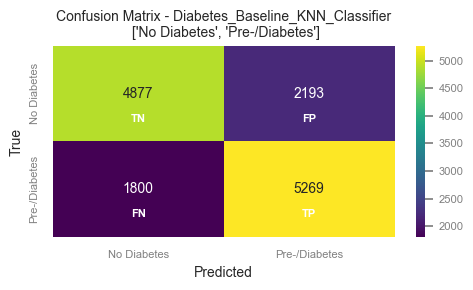


--- Generating Performance Curves ---


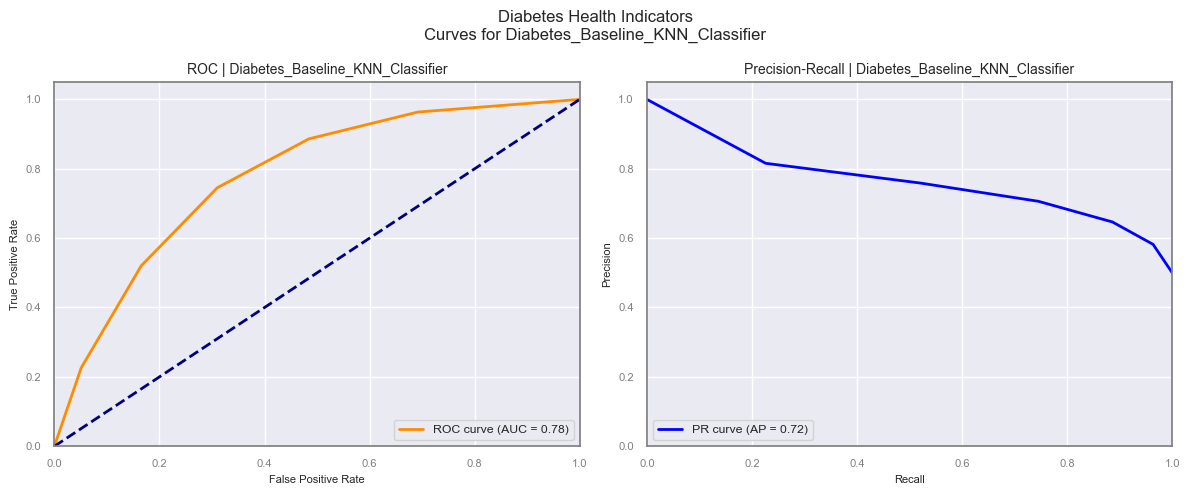

In [83]:
# VISUALIZATION: Confusion Matrix
print("\n--- Visualizing Confusion Matrix ---")
plt.figure(figsize = (5, 3))

plot_confusion_matrix(
    y_test,
    diabetes_results_baseline_knn['y_pred'],
    model_name   = diabetes_results_baseline_knn['metrics']['model_name'],
    labels       = list(dict_outcome.values()),
    ax           = plt.gca()
)
plt.show()


# ---  Model Visualization (ROC AUC and Precision-Recall) ---

print("\n--- Generating Performance Curves ---")

plt.figure(figsize = (12, 5))

# Plot 1: ROC AUC Curve using the enhanced function
plt.subplot(1, 2, 1)
plt.suptitle(f'{dataset_3a}\nCurves for {diabetes_results_baseline_knn["metrics"]["model_name"]}', fontsize=12)
plot_roc_auc_curve(
    diabetes_results_baseline_knn['classifier'],
    X_test_final,
    y_test,
    title   = f'ROC | {diabetes_results_baseline_knn["metrics"]["model_name"]}',
    ax      = plt.gca()
)

# Plot 2: Precision-Recall curve using the enhanced function
plt.subplot(1, 2, 2)
plot_precision_recall_curve(
    diabetes_results_baseline_knn['classifier'],
    X_test_final,
    y_test,
    title   = f'Precision-Recall | {diabetes_results_baseline_knn["metrics"]["model_name"]}',
    ax      = plt.gca()
)

plt.tight_layout()
plt.show()

In [84]:
metrics_diabetes_results_baseline_knn_df = pd.DataFrame(diabetes_results_baseline_knn['metrics'], index = [0])
metrics_diabetes_results_baseline_knn_df

,model_name,execution_time_seconds,mean_cv_accuracy,mean_cv_precision,mean_cv_recall,mean_cv_f1,test_accuracy
0,Diabetes_Baseline_KNN_Classifier,00:00:07,0.711704,0.700127,0.740642,0.7198,0.71759


### Diabetes | KNN - FFS

In [85]:
knn_model = KNeighborsClassifier(
    n_neighbors = 5,
    weights     = 'uniform',
    algorithm   = 'auto',
    leaf_size   = 30,
    p           = 2,
    n_jobs      = -1
)

diab_KNN_FFS = feature_selection(
    X               = X_train_final,
    y               = y_train,
    model           = knn_model,
    direction       = 'forward',
    scoring         = 'accuracy',  # Use a classification metric
    cv              = 5,
    tol             = 0.001,
    n_features_to_select = 15,     # Select top N features
    n_jobs          = -1,
    verbose         = True,
    exp_factor      = 1
)



Round 1:
Trying Adding feature 'BMI'         - Score: 0.5807
Trying Adding feature 'GenHlth'     - Score: 0.6492
Trying Adding feature 'MentHlth'    - Score: 0.4985
Trying Adding feature 'PhysHlth'    - Score: 0.5748
Trying Adding feature 'Age'         - Score: 0.5747
Trying Adding feature 'Education'   - Score: 0.5408
Trying Adding feature 'Income'      - Score: 0.5728
Trying Adding feature 'HighBP'      - Score: 0.6116
Trying Adding feature 'HighChol'    - Score: 0.5290
Trying Adding feature 'CholCheck'   - Score: 0.5147
Trying Adding feature 'Smoker'      - Score: 0.5000
Trying Adding feature 'Stroke'      - Score: 0.5061
Trying Adding feature 'HeartDiseaseorAttack' - Score: 0.5164
Trying Adding feature 'PhysActivity' - Score: 0.5142
Trying Adding feature 'Fruits'      - Score: 0.4893
Trying Adding feature 'Veggies'     - Score: 0.4876
Trying Adding feature 'HvyAlcoholConsump' - Score: 0.5111
Trying Adding feature 'AnyHealthcare' - Score: 0.4991
Trying Adding feature 'NoDocbcCost' 

### Diabetes | KNN - GridSearchCV

In [142]:

diab_knn_param_grid = {
    # Test a wide range of K values, e.g., 1 to 50
    # Two main weighting schemes: uniform or distance-weighted
    # Distance metrics: p=1 (Manhattan) or p=2 (Euclidean)
    # Algorithm: 'auto' chooses the best tree/brute-force implementation
    'n_neighbors':  list(range(1, 31)),
    'weights':      ['uniform', 'distance'],
    'p':            [1, 2],
    'algorithm':    ['auto']
}

Using HalvingGridSearchCV with halving factor 2...
n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 883
max_resources_: 56553
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 120
n_resources: 883
Fitting 5 folds for each of 120 candidates, totalling 600 fits


----------
iter: 1
n_candidates: 60
n_resources: 1766
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 2
n_candidates: 30
n_resources: 3532
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 3
n_candidates: 15
n_resources: 7064
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 4
n_candidates: 8
n_resources: 14128
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 5
n_candidates: 4
n_resources: 28256
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 56512
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 29, 'p': 1, 'weights': 'uniform'}
Best CV Score (accuracy): 0.7429
Test Accuracy: 0.7389
Execution Time: 00:01:20 seconds
Completed at: 2025-10-22 19:36:21

KNeighborsClassifier - HalvingGridSearchCV
Classification Report:
              precision    recall

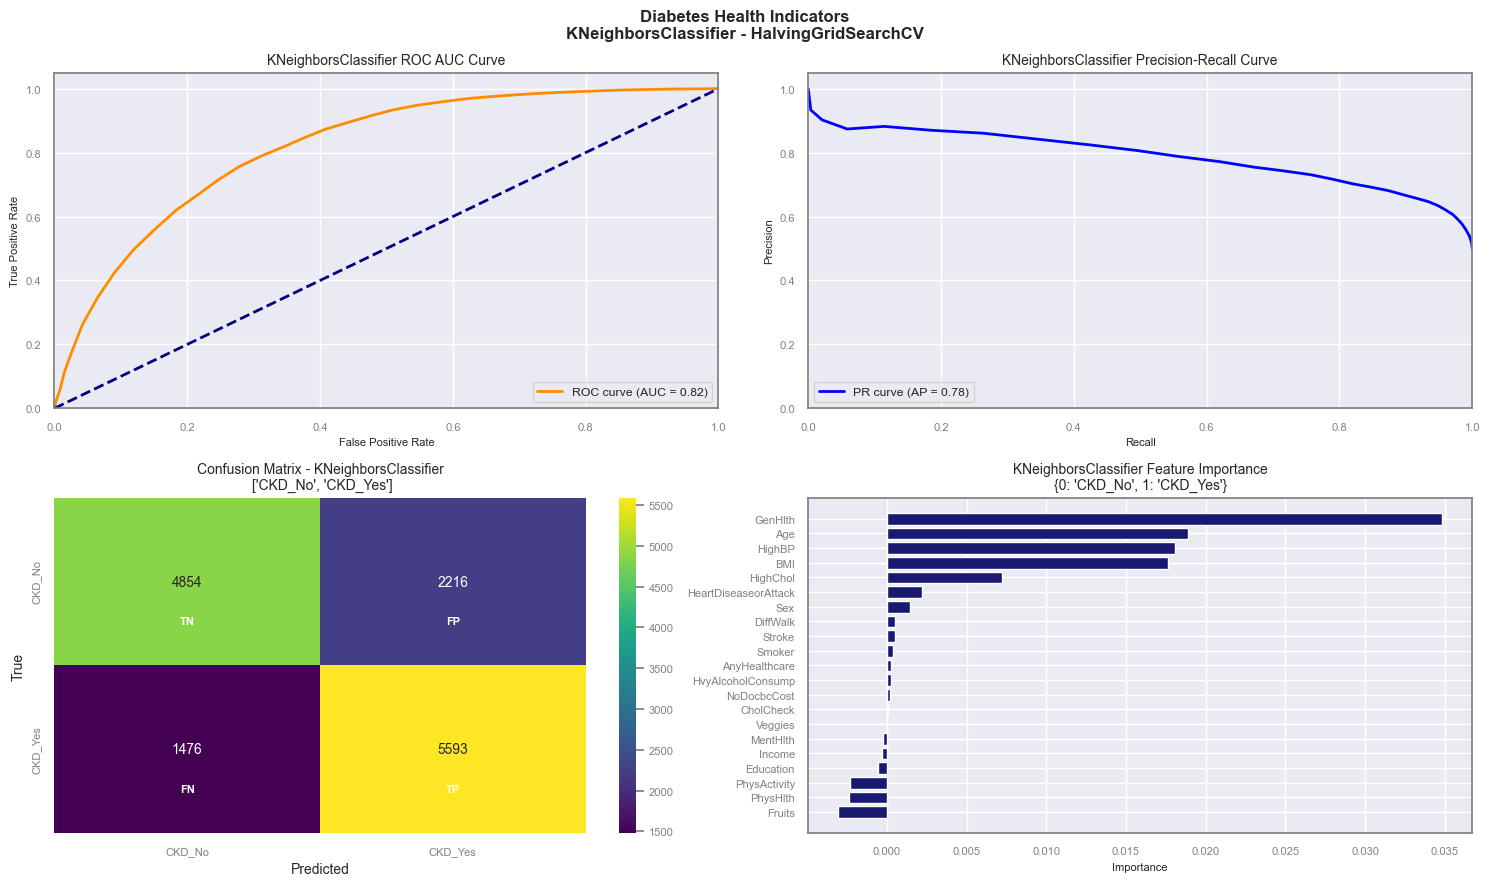

<Figure size 640x480 with 0 Axes>

In [ ]:
results_diab_KNN_gridCV = run_GridSearch_RandomizedSearch_CV(
    ensemble_model       = KNeighborsClassifier,
    dataset_name         = 'Diabetes Health Indicators',
    parameter_grid       = diab_knn_param_grid,
    X                    = X,
    X_train              = X_train_final,
    y_train              = y_train,
    X_test               = X_test_final,
    y_test               = y_test,
    classification_dict  = dict_outcome,
    CV_tuning_strategy   = 1,  # HalvingGridSearchCV
    iterations           = 10,
    cv_folds             = 5,
    random_state         = random_state,  # ✅ This is fine to pass
    scoring_metric       = 'accuracy'
)

best_params_df_knn = results_diab_KNN_gridCV[0]

In [138]:
best_params_df_knn

,algorithm,n_neighbors,p,weights,Dataset,Model,Strategy,Scoring_Metric,Best_CV_Score,Test_Accuracy,execution_time,timestamp
0,auto,29,1,uniform,Diabetes Health Indicators,KNeighborsClassifier,HalvingGridSearchCV,accuracy,0.742921,0.738878,00:01:20,2025-10-22 19:36:21


## <font color='plum'> 3.c. Chronic Kidney Disease Dataset

Contains comprehensive data for 1,659 patients, including 54 variables spanning medical history, lab results, medication usage, quality of life, and environmental
exposure. Ideal for regression, classification, and clustering analyses.
https://www.kaggle.com/datasets/rabieelkharoua/chronic-kidney-disease-dataset-analysis

### Load & Clean - CKD

In [150]:
file_path  = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
file_name  = "Chronic_Kidney_Dsease_data.csv"
dataset_3c = 'Chronic Kidney Disease Prediction'

# Load the latest version
df_3c = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)

df_3c.columns       = df_3c.columns.str.strip()
columns_to_drop     = ['PatientID', 'DoctorInCharge']
df_3c.drop(columns  = columns_to_drop, inplace = True, errors = 'ignore')

# for stupid confusion matrix plot
classification_dict_CKD = {
    0: 'No CKD',
    1: 'CKD'
}

X_train_CKD, X_test_CKD, y_train_CKD, y_test_CKD, X_CKD = prepare_data(
    df              = df_3c,
    target_col      = 'Diagnosis',
    test_size       = test_size,
    random_state    = random_state
)


print("X_train:", X_train_CKD.shape)
print("y_train:", y_train_CKD.shape)
print("X_test:", X_test_CKD.shape)
print("y_test:", y_test_CKD.shape)


Target variable 'Diagnosis' encoded successfully.
Dropped rows with NaNs. Initial rows: 1659, Final rows: 1659
Percentage of data retained: 100.00%

Applied robust data type coercion to feature columns.
Data Split: Training set size = 1327, Test set size = 332

--- Manual Feature Scaling ---
Scaling Complete.

X_train: (1327, 51)
y_train: (1327,)
X_test: (332, 51)
y_test: (332,)


### CKD | KNN - Baseline

In [151]:
# Run KNN Classifier with manually preprocessed data
results_CKD_baseline_knn = run_knn_classifier(
    X_train      = X_train_CKD,
    y_train      = y_train_CKD,
    X_test       = X_test_CKD,
    y_test       = y_test_CKD,
    model_name   = 'CKD_Baseline_KNN_Classifier',
    dict_outcome = dict_outcome,
    n_neighbors  = 5,         # You can tune this
    weights      = 'distance', # Try 'distance' for weighted voting
    p            = 2,         # 2 = Euclidean, 1 = Manhattan
    n_jobs       = -1,
    n_splits     = 5,
    n_repeats    = 5,
    random_state = random_state
)


--- Final CKD_Baseline_KNN_Classifier Evaluation ---
Final Test Accuracy: 0.9127

Confusion Matrix (Test Set)
          CKD_No  CKD_Yes
CKD_No        0       27
CKD_Yes       2      303 

Classification Report (Test Set)
              precision    recall  f1-score   support

      CKD_No       0.00      0.00      0.00        27
     CKD_Yes       0.92      0.99      0.95       305

    accuracy                           0.91       332
   macro avg       0.46      0.50      0.48       332
weighted avg       0.84      0.91      0.88       332
 

Mean CV Accuracy: model correctly classifies ~ 0.9177 of instances across 25 different training-validation splits
Mean CV Precision: when model predicts the positive class, it's correct ~ 0.9198 of the time.
Mean CV Recall: model correctly identifies ~ 0.9974 of all actual positive cases (True Positives).
Mean CV F1 Score: the harmonic mean of precision and recall is 0.9570


In [152]:
metrics_results_CKD_baseline_knn_df = pd.DataFrame(results_CKD_baseline_knn['metrics'], index = [0])
metrics_results_CKD_baseline_knn_df

,model_name,execution_time_seconds,mean_cv_accuracy,mean_cv_precision,mean_cv_recall,mean_cv_f1,test_accuracy
0,CKD_Baseline_KNN_Classifier,00:00:01,0.917715,0.919802,0.997371,0.956973,0.912651


### CKD | KNN - GridSearchCV

In [153]:

CKD_knn_param_grid = {
    # Test a wide range of K values, e.g., 1 to 50
    # Two main weighting schemes: uniform or distance-weighted
    # Distance metrics: p=1 (Manhattan) or p=2 (Euclidean)
    # Algorithm: 'auto' chooses the best tree/brute-force implementation
    'n_neighbors':  list(range(1, 31)),
    'weights':      ['uniform', 'distance'],
    'p':            [1, 2],
    'algorithm':    ['auto']
}

Using GridSearchCV...
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
Best CV Score (accuracy): 0.9194
Test Accuracy: 0.9217
Execution Time: 00:00:02 seconds
Completed at: 2025-10-22 20:49:30

KNeighborsClassifier - GridSearchCV
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.0370    0.0714        27
           1     0.9215    1.0000    0.9591       305

    accuracy                         0.9217       332
   macro avg     0.9607    0.5185    0.5153       332
weighted avg     0.9278    0.9217    0.8869       332

Train Accuracy: 0.9209
Test Accuracy: 0.9217


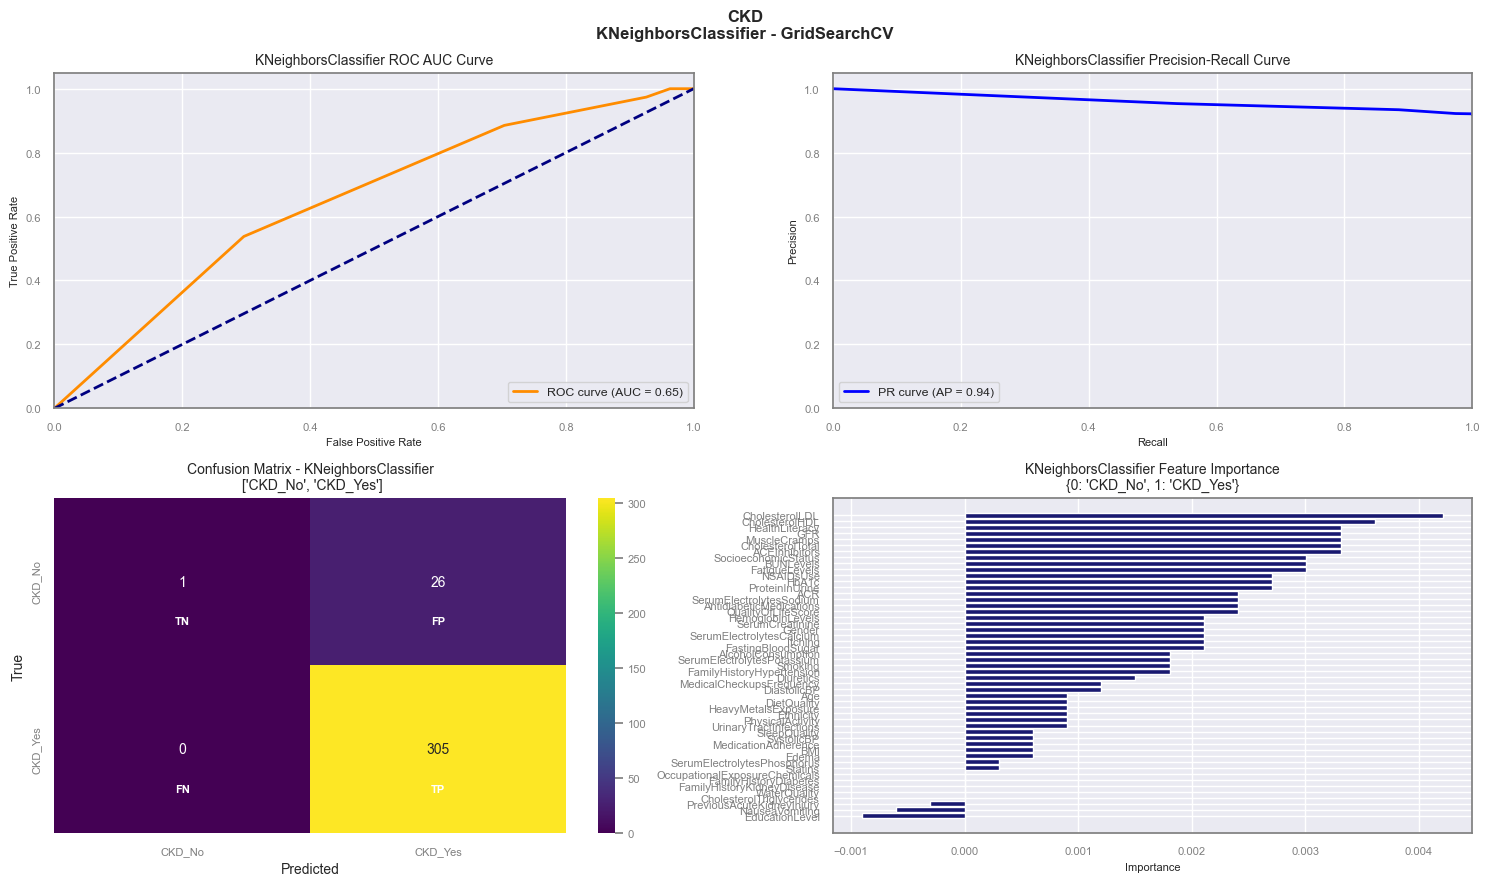

<Figure size 640x480 with 0 Axes>

In [155]:
results_CKD_KNN_gridCV = run_GridSearch_RandomizedSearch_CV(
    ensemble_model       = KNeighborsClassifier,
    dataset_name         = 'CKD',
    parameter_grid       = CKD_knn_param_grid,
    X                    = X,
    X_train              = X_train_CKD,
    y_train              = y_train_CKD,
    X_test               = X_test_CKD,
    y_test               = y_test_CKD,
    classification_dict  = dict_outcome,
    CV_tuning_strategy   = 2,  # HalvingGridSearchCV
    iterations           = 5,
    cv_folds             = 5,
    random_state         = random_state,  # ✅ This is fine to pass
    scoring_metric       = 'accuracy'
)

best_params_df_knn = results_diab_KNN_gridCV[0]

In [156]:
best_params_df_knn

,algorithm,n_neighbors,p,weights,Dataset,Model,Strategy,Scoring_Metric,Best_CV_Score,Test_Accuracy,execution_time,timestamp
0,auto,29,1,uniform,Diabetes Health Indicators,KNeighborsClassifier,HalvingGridSearchCV,accuracy,0.742921,0.738878,00:01:20,2025-10-22 19:36:21


## Notes


### <font color='gold'><i>Why would we use the Manhattan distance in case there are outliers? 
</i></font>

<font color='plum'>

Using **Manhattan distance** (also known as **L1 norm**) instead of **Euclidean distance** (L2 norm) can be beneficial in the presence of **outliers**:

#### 1. Robustness to Outliers
- **Euclidean distance** squares the differences between coordinates, which **amplifies the effect of outliers**. A single large deviation in one dimension can dominate the overall distance.
- **Manhattan distance**, on the other hand, **sums the absolute differences**, treating all deviations linearly. This makes it **less sensitive** to extreme values in any one dimension.

#### 2. Better Performance in High-Dimensional Spaces
- In high-dimensional data, outliers are more common and can distort clustering or classification results.
- Manhattan distance tends to perform better in such cases because it doesn't disproportionately penalize large deviations.

#### 3. Sparsity and Feature Selection
- When dealing with sparse data (e.g., text data represented as word counts), Manhattan distance can be more appropriate because it emphasizes the presence or absence of features rather than their magnitude.

#### Example:
Imagine two points:
- Point A: (1, 1)
- Point B: (100, 1)

- **Euclidean distance**:  
  $$\sqrt{(100 - 1)^2 + (1 - 1)^2} = \sqrt{9801} = 99$$

- **Manhattan distance**:  
  $$|100 - 1| + |1 - 1| = 99 + 0 = 99$$

Now if Point B was (1000, 1), Euclidean distance becomes 999, but Manhattan distance is still 999. The key difference is that Euclidean distance grows faster due to squaring, making it more sensitive to large deviations.



### <font color='gold'><i>When p is a very large number (say, 1,000,000), what does the Minkowski distance behave like? (This is sometimes referred to as ﻿p equals infinity﻿.) That is, use Python to try computing `(x^p + y^p)^(1/p)` for large p and for different values of x and y — what do you get? </i></font>

<font color='plum'>

#### Minkowski Distance Formula:
$$(x^p + y^p)^{1/p}$$

#### Observations from the Computation:

For pairs of values \((x, y)\) and increasing values of \( p \):

#### Example: \( x = 3, y = 5 \)
- \( p = 10 \): Distance ≈ **5.003**
- \( p = 100 \): Distance ≈ **5.0**
- \( p = 1000 \): **OverflowError**
- \( p = 1,000,000 \): **OverflowError**

#### Example: \( x = 1, y = 100 \)
- \( p = 10 \): Distance ≈ **100.000**
- \( p = 100 \): Distance ≈ **100.000**
- Larger \( p \): **OverflowError**

#### Insight:
As \( p \to \infty \), the Minkowski distance **approaches the maximum** of the absolute values of the coordinates:

$$(x^p + y^p)^{1/p} \to \max(|x|, |y|)$$

This is known as the **Chebyshev distance** or **L∞ norm**.

#### Summary:
- For large \( p \), the Minkowski distance becomes dominated by the **largest component**.
- This makes it useful in scenarios where the **maximum deviation** matters more than the cumulative or average deviation.
- However, **numerical overflow** can occur for extremely large \( p \), so it's often better to directly use the max function when approximating the L∞ norm.

In [89]:

#  function to compute Minkowski distance

def minkowski_distance(x, y, p):
    return (x**p + y**p)**(1/p)

# Test values for x and y
values = [(3, 5), (10, 20), (1, 100), (50, 100)]
# Large p values
p_values = [10, 100, 1000, 1000000]

# Compute and display
for x, y in values:
    print(f"x = {x}, y = {y}")
    for p in p_values:
        try:
            dist = minkowski_distance(x, y, p)
            print(f"  p = {p}: Minkowski distance = {dist}")
        except OverflowError:
            print(f"  p = {p}: OverflowError")
    print("")

# Additionally, compute the limit as p approaches infinity
# This is equivalent to max(x, y)
print("As p --> approaches infinity, Minkowski distance --> max(x, y):")
for x, y in values:
    print(f"x = {x}, y = {y}, max(x, y) = {max(x, y)}")

x = 3, y = 5
  p = 10: Minkowski distance = 5.003015113809089
  p = 100: Minkowski distance = 5.0
  p = 1000: OverflowError
  p = 1000000: OverflowError

x = 10, y = 20
  p = 10: Minkowski distance = 20.001952267223597
  p = 100: Minkowski distance = 20.0
  p = 1000: OverflowError
  p = 1000000: OverflowError

x = 1, y = 100
  p = 10: Minkowski distance = 100.00000000000003
  p = 100: Minkowski distance = 100.00000000000001
  p = 1000: OverflowError
  p = 1000000: OverflowError

x = 50, y = 100
  p = 10: Minkowski distance = 100.00976133611799
  p = 100: Minkowski distance = 100.00000000000001
  p = 1000: OverflowError
  p = 1000000: OverflowError

As p --> approaches infinity, Minkowski distance --> max(x, y):
x = 3, y = 5, max(x, y) = 5
x = 10, y = 20, max(x, y) = 20
x = 1, y = 100, max(x, y) = 100
x = 50, y = 100, max(x, y) = 100


### <font color='gold'><i>Can there be outliers if we standardize the data, or does the standardizing get rid of the outliers? (Prove that there can still be outliers!) 
</i></font>

<font color='plum'>
Standardization (z-score normalization) transforms data to have a mean of 0 and a standard deviation of 1, but it does not remove outliers. Instead, it rescales them, often making them more apparent as they lie far from the mean in standardized units.

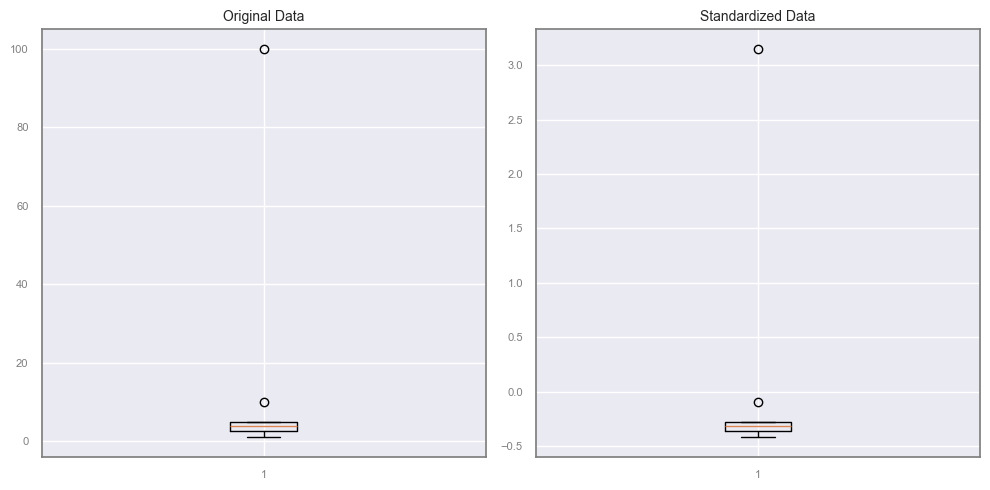

In [90]:
# Generate a dataset with outliers
data = np.array([1, 2, 2, 3, 3, 4, 4, 5, 5, 10, 100]).reshape(-1, 1)

# Standardize the data
scaler              = StandardScaler()
standardized_data   = scaler.fit_transform(data)

# Plot boxplots of original and standardized data
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original data boxplot
axes[0].boxplot(data)
axes[0].set_title('Original Data')

# Standardized data boxplot
axes[1].boxplot(standardized_data)
axes[1].set_title('Standardized Data')

plt.tight_layout()
plt.show()

### <font color='gold'>*Why might we choose cosine distance instead of Euclidean or Manhattan when comparing documents or other data where the direction of features matters more than their size?*</font>

<font color='plum'>

**Cosine distance** is often preferred over **Euclidean** or **Manhattan distance** when comparing documents or other high-dimensional data where **direction matters more than magnitude**. 

#### What is Cosine Distance?
Cosine distance measures the **angle** between two vectors, not their magnitude. It’s defined as:

$$
\text{Cosine similarity} = \frac{\vec{A} \cdot \vec{B}}{||\vec{A}|| \cdot ||\vec{B}||}
$$

Cosine **distance** is then:

$$
\text{Cosine distance} = 1 - \text{Cosine similarity}
$$

#### Why Use Cosine Distance for Documents?

1. Magnitude Doesn't Matter:
   - In document comparison, the number of times a word appears (frequency) can vary widely.
   - Two documents might use the same words but in different quantities. Cosine distance focuses on the **pattern of word usage**, not how many times each word appears.

2. Focus on Direction:
   - Cosine distance treats documents as vectors in a high-dimensional space (each dimension = a word).
   - It compares the **orientation** of these vectors, which reflects the **relative importance** of words rather than their absolute counts.

3. Normalization Built-In:
   - Since cosine similarity uses normalized vectors, it inherently adjusts for document length. This is crucial when comparing documents of different sizes.

#### Example:

Consider two documents:

- Doc A: "Data science is fun"
- Doc B: "Data science is very fun"

Even though Doc B has one extra word ("very"), the **direction** of the word frequency vector is similar to Doc A. Cosine similarity will be high, indicating they are similar, even though Euclidean or Manhattan distances might suggest otherwise due to the extra word.

####  Summary:

| Metric         | Sensitive to Magnitude? | Good for Text/Data with Directional Importance? |
|----------------|-------------------------|--------------------------------------------------|
| Euclidean      | ✅ Yes                  | ❌ No                                             |
| Manhattan      | ✅ Yes                  | ❌ No                                             |
| Cosine Distance| ❌ No                   | ✅ Yes                                            |
